# Wine dataset sample
taken from the Google ML course colab: https://colab.research.google.com/github/google/eng-edu/blob/main/ml/testing-debugging/testing-debugging-regression.ipynb?utm_source=ss-testing-debugging&utm_campaign=colab-external&utm_medium=referral&utm_content=testing-debugging-regression

In [2]:
# Load libraries
from os.path import join # for joining file pathnames
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

wineDf = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/winequality.csv",
  encoding='latin-1')
wineDf.columns = ['fixed acidity','volatile acidity','citric acid',
                     'residual sugar','chlorides','free sulfur dioxide',
                     'total sulfur dioxide','density','pH',
                     'sulphates','alcohol','quality']
wineDf.head()

Matplotlib is building the font cache; this may take a moment.
2023-07-12 22:31:46.546764: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 22:31:46.624525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 22:31:48.230048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.3,0.4,20.7,0.0,45.0,170.0,1.0,3.0,0.5,8.8,6
1,6.3,0.3,0.3,1.6,0.0,14.0,132.0,1.0,3.3,0.5,9.5,6
2,8.1,0.3,0.4,6.9,0.1,30.0,97.0,1.0,3.3,0.4,10.1,6
3,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
4,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6


## Check Correlation Matrix

<Axes: >

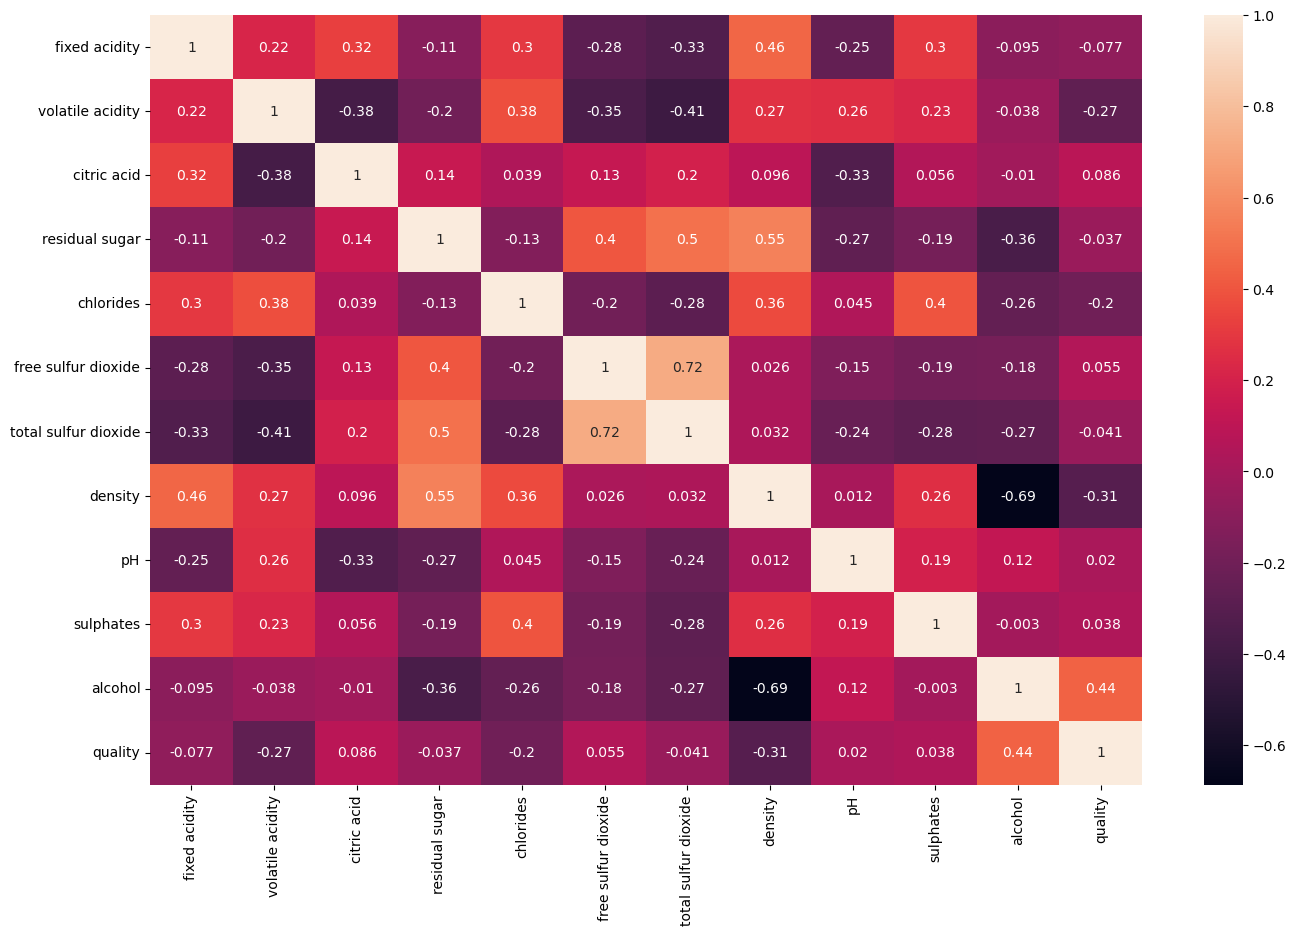

In [3]:
corr_wineDf = wineDf.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_wineDf, annot=True)

In [3]:
# Describe sample
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0
mean,7.2,0.3,0.3,5.4,0.1,30.5,115.7,1.0,3.2,0.5,10.5,5.8
std,1.3,0.2,0.1,4.8,0.0,17.7,56.5,0.0,0.2,0.1,1.2,0.9
min,3.8,0.1,0.0,0.6,0.0,1.0,6.0,1.0,2.7,0.2,8.0,3.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,77.0,1.0,3.1,0.4,9.5,5.0
50%,7.0,0.3,0.3,3.0,0.0,29.0,118.0,1.0,3.2,0.5,10.3,6.0
75%,7.7,0.4,0.4,8.1,0.1,41.0,156.0,1.0,3.3,0.6,11.3,6.0
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9,9.0


### Normalization using z-score

In [4]:
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality',inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

def normalizeData(arr):
  stdArr = np.std(arr)
  meanArr = np.mean(arr)
  arr = (arr-meanArr)/stdArr
  return arr

for str1 in wineFeatures.columns:
   wineFeatures[str1] = normalizeData(wineFeatures[str1])

## Test Engineered Data

After normalizing your data, you should test your engineered data for errors as described in Data and Feature Debugging. In this section, you will test that engineering data:

    Has the expected number of rows and columns.
    Does not have null values.

First, set up the testing functions by running the following code cell:


In [6]:
import unittest

def test_input_dim(df, n_rows, n_columns):
  assert len(df) == n_rows, "Unexpected number of rows."
  assert len(df.columns) == n_columns, "Unexpected number of columns."
  print('Engineered data has the expected number of rows and columns.')

def test_nulls(df):
  dataNulls = df.isnull().sum().sum()
  assert dataNulls == 0, "Nulls in engineered data."
  print('Engineered features do not contain nulls.')

#@title Test dimensions of engineered data
wine_feature_rows = 6497 #@param
wine_feature_cols = 11 #@param
test_input_dim(wineFeatures,
               wine_feature_rows,
               wine_feature_cols)

test_nulls(wineFeatures)

Engineered data has the expected number of rows and columns.
Engineered features do not contain nulls.


## Check Splits for Statistical Equivalence
As described in the [Data Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors) guidelines, before developing your model, you should check that your training and validation splits are equally representative. Assuming a training:validation split of 80:20, compare the mean and the standard deviation of the splits by running the next two code cells. Note that this comparison is not a rigorous test for statistical equivalence but simply a quick and dirty comparison of the splits.

In [7]:
splitIdx = wineFeatures.shape[0]*8//10
wineFeatures.iloc[0:splitIdx,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0
mean,-0.2,-0.3,0.1,0.2,-0.2,0.2,0.3,-0.2,-0.1,-0.2,-0.0
std,0.7,0.8,0.9,1.1,0.9,1.0,0.8,1.0,1.0,0.9,1.0
min,-2.6,-1.6,-2.2,-1.0,-1.3,-1.6,-1.9,-2.5,-3.1,-2.1,-2.1
25%,-0.7,-0.8,-0.4,-0.8,-0.6,-0.5,-0.2,-1.0,-0.8,-0.8,-0.9
50%,-0.3,-0.4,-0.1,-0.1,-0.3,0.1,0.3,-0.2,-0.2,-0.3,-0.2
75%,0.1,0.0,0.5,0.9,-0.1,0.8,0.9,0.6,0.4,0.2,0.7
max,6.0,6.0,9.2,12.7,15.8,14.6,5.7,14.8,4.2,9.9,3.1


In [8]:
wineFeatures.iloc[splitIdx:-1,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0
mean,0.9,1.1,-0.3,-0.6,0.8,-0.8,-1.3,0.7,0.6,0.8,0.0
std,1.4,1.1,1.3,0.3,1.1,0.6,0.6,0.7,1.0,1.0,0.9
min,-1.8,-1.3,-2.2,-1.0,-1.3,-1.7,-1.9,-1.5,-2.2,-1.1,-1.8
25%,-0.1,0.3,-1.5,-0.7,0.4,-1.3,-1.7,0.3,-0.1,0.1,-0.7
50%,0.6,1.0,-0.3,-0.7,0.7,-0.9,-1.4,0.7,0.5,0.6,-0.1
75%,1.7,1.8,0.8,-0.6,1.0,-0.5,-1.0,1.1,1.1,1.3,0.7
max,6.7,7.5,3.2,2.1,10.4,2.3,3.1,3.0,4.9,7.3,3.7


The two splits are clearly not equally representative. To make the splits equally representative, you can shuffle the data.
Run the following code cell to shuffle the data, and then recreate the features and labels from the shuffled data.

In [9]:
# Shuffle data
wineDf = wineDf.sample(frac=1).reset_index(drop=True)
# Recreate features and labels
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality',inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

## Establish a Baseline

For a regression problem, the simplest baseline to predict the average value. Run the following code to calculate the mean-squared error (MSE) loss on the training split using the average value as a baseline. Your loss is approximately 0.75. Any model should beat this loss to justify its use.

In [10]:
baselineMSE = np.square(wineLabels[0:splitIdx]-np.mean(wineLabels[0:splitIdx]))
baselineMSE = np.sum(baselineMSE)/len(baselineMSE)
print(baselineMSE)

0.7651833888713864


### Linear Model
Following good ML dev practice, let's start with a linear model that uses the most informative feature from the correlation matrix: alcohol. Even if this model performs badly, we can still use it as a baseline. This model should beat our previous baseline's MSE of 0.75.

2023-04-19 16:45:35.671518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Final training loss: 0.6211275458335876
Final Validation loss: 0.6125752329826355


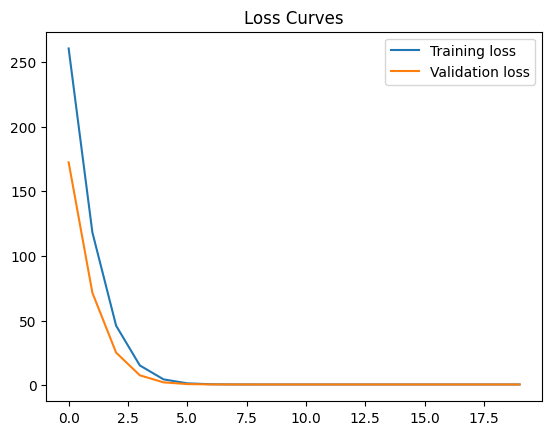

In [12]:
def showRegressionResults(trainHistory):
  """Function to:
   * Print final loss.
   * Plot loss curves.
  
  Args:
    trainHistory: object returned by model.fit
  """
  
  # Print final loss
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final Validation loss: " + str(trainHistory.history['val_loss'][-1]))
  
  # Plot loss curves
  plt.plot(trainHistory.history['loss'])
  plt.plot(trainHistory.history['val_loss'])
  plt.legend(['Training loss','Validation loss'],loc='best')
  plt.title('Loss Curves')

# Execute the model and plot

model = None
# Choose feature
wineFeaturesSimple = wineFeatures['alcohol']
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mse')
# Train the model!
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100, # set batch size here
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

### Non linear optimized model

Final training loss: 0.5653565526008606
Final Validation loss: 0.5689287185668945


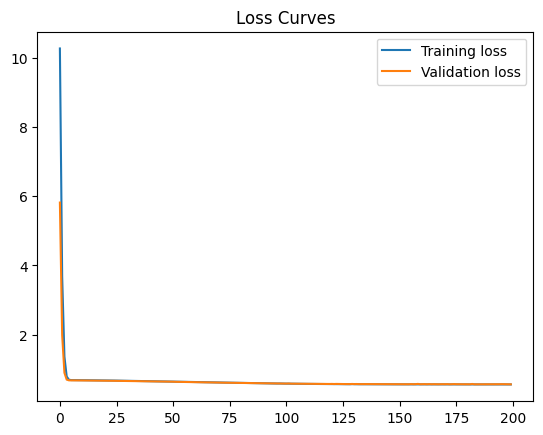

In [13]:
# Choose features
wineFeaturesSimple = wineFeatures[['alcohol','volatile acidity','chlorides','density']]
# Define
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             activation='relu',
                             input_dim=wineFeaturesSimple.shape[1]))
# Add more layers here
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=200,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)